Source: https://www.kaggle.com/code/liamhealy/interest-rate-modelling-in-python/notebook

Introduction
This notebook is part of a series of notebooks which explore Data Science topics in Python:

Bayesian Hyperparameter Tuning in Python
Copulas in Python
Shapley Values in Python
Principle Component Analysis in Python
Interest Rate Modelling in Python
The purpose of this notebook to to develope an yield curve forecasting model that can be leveraged to predict the rance of interest rate yield curve outlooks across the next 12-months (or more). The methodology outlines in this notebook will leverage dimension reduction techniques and stocastic modelling.

Utilizing Principal Component Analysis (PCA) and the Vasicek simulation model proves invaluable in simulating and understanding the complex dynamics of US yield curves. PCA identifies key factors influencing interest rate variations, enabling a more concise representation of yield curve movements. The Vasicek model, incorporating mean reversion, then facilitates the stochastic simulation of future interest rate paths. By integrating PCA-derived principal components into the Vasicek framework, analysts can enhance the granularity of simulations, capturing both systematic factors and the inherent uncertainty in interest rate changes. This combined approach finds applications in risk management, scenario analysis, and portfolio optimization, empowering financial analysts to make more informed decisions by comprehensively simulating the intricate behavior of US yield curves.

In [ ]:
# %pip install seaborn
# %pip install plotly

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------- ----------------------- 4.2/9.9 MB 22.9 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.9 MB 23.1 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 18.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Evironment setup

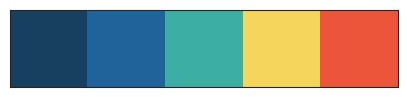

In [1]:
# Import the required packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler

# Plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.optimize import minimize

### Define the colour scheme
c1 = "#173f5f"
c2 = "#20639b"
c3 = "#3caea3"
c4 = "#f6d55c"
c5 = "#ed553b"

custom_palette = [c1, c2, c3, c4, c5]
sns.palplot(sns.color_palette(custom_palette))

# User defined function
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#total'] = df.shape[0]
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    summ['#duplicates'] = summ['#total'] - summ['#unique']
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

Data Processing

In [5]:
# Import the data
df = pd.read_csv('./yield-curve-rates-1990-2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)

# Sort by Date
df = df.sort_values('Date')

# Date as index
df.set_index('Date', inplace=True)

# List the variables to keep (<25% missing) and rename
keep_vars = ['3 Mo','6 Mo','1 Yr','2 Yr','3 Yr','5 Yr','7 Yr','10 Yr','20 Yr']
rename_vars = ['3m','6m','12m','24m','36m','60m','84m','120m','240m']

# drop variable and rename
df = df[keep_vars] #Selects only the columns listed in keep_vars
df.columns = rename_vars #Assigns the new column names

# Interpolate missing values linearly
df = df.interpolate()

# Drop rows with missing values still (when missing at beginning or end of time series)
df = df.dropna()

# View the data
summary(df).style.background_gradient(cmap='Blues')

,data type,#total,#missing,%missing,#unique,#duplicates,min,max
3m,float64,7818,0,0.000000,631,7187,0.000000,6.420000
6m,float64,7818,0,0.000000,638,7180,0.020000,6.670000
12m,float64,7818,0,0.000000,686,7132,0.040000,7.320000
24m,float64,7818,0,0.000000,729,7089,0.090000,7.740000
36m,float64,7818,0,0.000000,748,7070,0.100000,7.840000
60m,float64,7818,0,0.000000,742,7076,0.190000,7.900000
84m,float64,7818,0,0.000000,733,7085,0.360000,7.920000
120m,float64,7818,0,0.000000,726,7092,0.520000,8.050000
240m,float64,7818,0,0.000000,716,7102,0.870000,8.300000


In [6]:
df.head()

,3m,6m,12m,24m,36m,60m,84m,120m,240m
Date,,,,,,,,,
1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12
1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10
1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12
1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12
1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11


Visualising Data

In [8]:
def plot_rates(df):
    plot_vars = df.columns
    
    fig, ax = plt.subplots(figsize=(8,4), ncols=1, nrows=1)
    for var in plot_vars: #for each column
        ax.plot(df.index, df[var], label=var, lw=0.5)
    ax.set(title='Daily Interest Rate', xlabel='Date', ylabel='Interest Rate (%)')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.show()

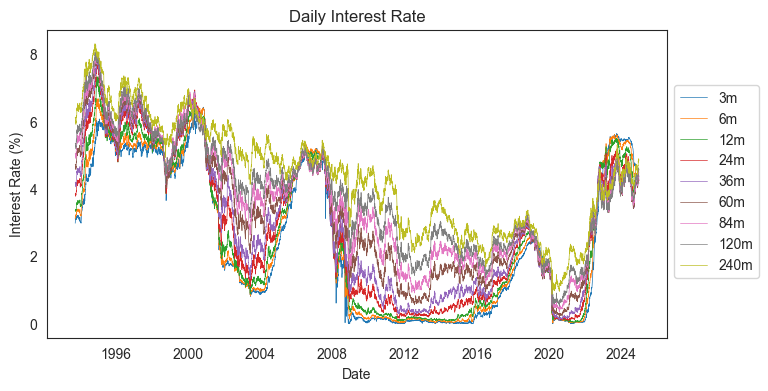

In [9]:
# Plot the daily interest rates
plot_rates(df)

Principle Component Analysis
The purpose of this section is to decompose the yield curve into principle components and then recontruct the original yield curve using a subset of the principle components to assess the accuracy of PCA before extrapolation. The steps required to estimate the dimension reduction error includes:

Standardising the interest rate time series
Computing the covariance matrix
Eigenvalue and eigenvector decomposition
Selecting principle components
reconstructing the interest rates from the principle component scores

Standardising the Data 
Now that the dataset has been loaded, it must be prepared for dimensionality reduction. The majority of machine learning and optimization algorithms perform better when all the features are along the same scale. In order to do this a standardization approach can be implemented. A feature value  
x
i
  can be become a standardized feature value  
x
i
s
  by using the following calculation

  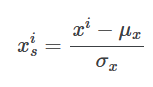

  where  
μ
x
  is the mean of the feature column and $\sigma_x" is the corresponding sample variance. This results in the feature values having a mean of 0 and a standard deviation of 1, therefore having the same parameters as a normal distribution. As an example, for a feature column with values from 0 to 5 applying standardization would result in the following new values:

In [ ]:
# Standaardiseren schaalt features; het verandert de vorm van de verdeling nie

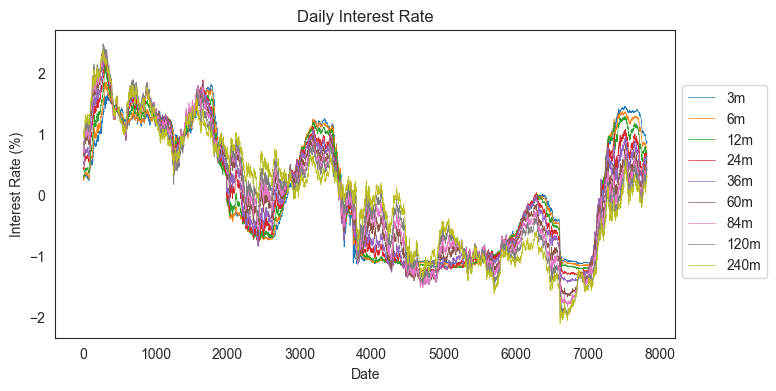

In [10]:
# Create instance of scalar
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(np.array(df)))
df_scaled.columns = df.columns

# Plot the scalared dataset
plot_rates(df_scaled)

Compute Covariance Matrix 
Covariance measures how two features vary with each other. A positive covariance indicates that features increase and decrease together. Whereas, a negative covariance indicates that the two features vary in the opposite directions. For two feature vectors xⱼ and xₖ the covariance between them σⱼₖ can be calculated using the following equation:

A covariance matrix contains the covariance values between features and has shape d × d. For our dataset, the covariance matrix should, therefore, look like the following:

Since the feature columns have been standardized and therefore they each have a mean of zero, the covariance matrix Σ can be calculated by the following:

where Xᵗ is the transpose of X.

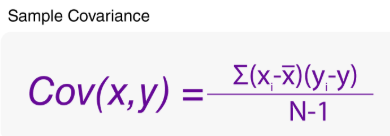

In [ ]:
# cov in hoeverre ze samen bewegen, zegt niet in welke mate corr zegt dit wel op schaal van -1 tot 1
# standaardiseren (mean=0, std=1) zorgt dat variabelen dezelfde schaal hebben zodat de covariantiematrix niet door groot-geschaalde kolommen wordt gedomineerd. 
# moet het wel gestandardiseerd zijn

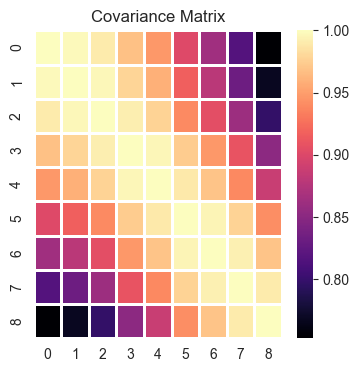

In [ ]:
# Compute covariance matrix
X = np.array(df_scaled)
cov = (X.T @ X) / (X.shape[0] - 1) # cov formule met gem = 0, want gestandaardiseerd
# X.shape[0] = aantal rijen = n = aantal

# Display the covariance matix
fig, ax = plt.subplots(figsize=(4,4)) # maakt een nieuwe figuur en assen aan.
sns.heatmap(cov, cmap='magma',linecolor='white',linewidths=1, ax=ax)
ax.set(title="Covariance Matrix")
plt.show()

#### Eigenvalue and Eigenvector Decomposition 
The eigenvectors represent the principal components (the directions of maximum variance) of the covariance matrix. The eigenvalues are their corresponding magnitude. The eigenvector that has the largest corresponding eigenvalue represents the direction of maximum variance. An eigenvector v satisfies the following condition:

Where λ is a scalar and known as the eigenvalue.

In [ ]:
#Elke eigenvector = een richting in de ruimte van al je features.
#De eigenvalue zegt hoeveel variantie die eigenvector verklaart.

In [27]:
# Eigenvalue and eigenvectors
eig_values, eig_vectors = np.linalg.eig(cov)

# View the eigenvalues and vectors
print("Eigenvalues:\t", eig_values[0])
print("Eigenvectors:\t", eig_vectors[0])

Eigenvalues:	 8.420385374121867
Eigenvectors:	 [-0.32629357  0.41772875  0.48801126 -0.46644168  0.31795739 -0.33543539
  0.06799066  0.21226796 -0.00426038]


#### Selecting Principle Components 
Now that the eigenpairs have been computed they now need to be sorted based on the magnitude of their eigenvalues. Now that the principal components have been sorted based on the magnitude of their corresponding eigenvalues, it is time to determine how many principal components to select for dimensionality reduction. This can be done by plotting the cumulative sum of the eigenvalues.

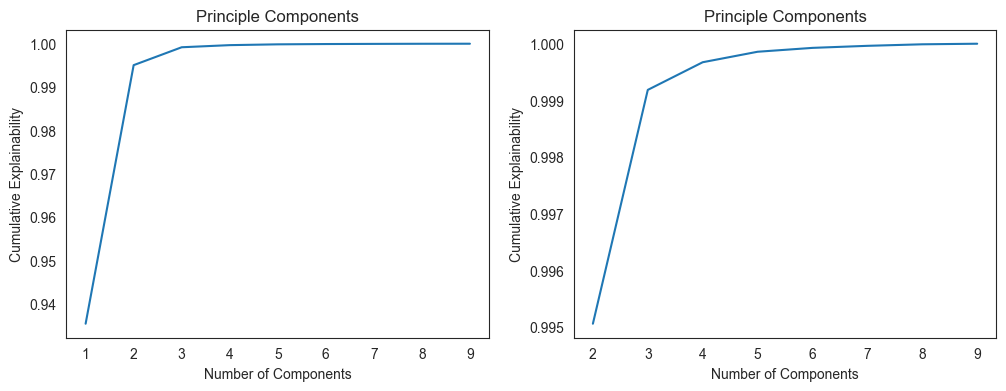

In [ ]:
# Sort the eigenvectors
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]

# Cumulative sum of the eigenvalues
cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)

# Plot the explainability by the number of components
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
ax[0].plot(xint, cumsum)
ax[0].set(title='Principle Components', xlabel='Number of Components', ylabel='Cumulative Explainability')

ax[1].plot(xint[1:], cumsum[1:]) # start op index 1 om de eerste component (0) weg te laten
ax[1].set(title='Principle Components', xlabel='Number of Components', ylabel='Cumulative Explainability')
plt.show()

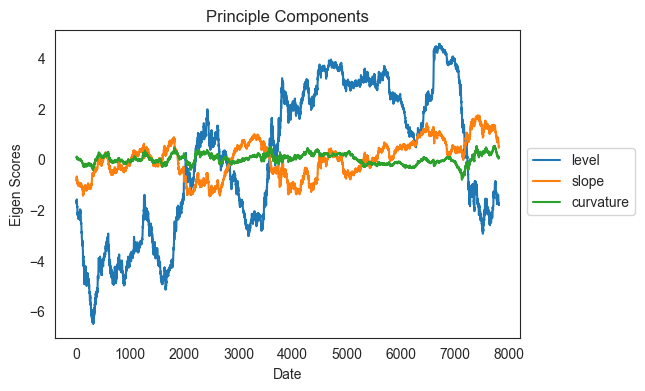

                 PC1       PC2       PC3
Date                                    
2024-12-17 -1.639561  0.625158  0.072150
2024-12-18 -1.760472  0.567244  0.013799
2024-12-19 -1.795128  0.504340  0.033614
2024-12-20 -1.746413  0.534032  0.044209
2024-12-23 -1.806804  0.487054  0.045993
2024-12-24 -1.804418  0.495076  0.055526
2024-12-26 -1.785558  0.497300  0.046755
2024-12-27 -1.807347  0.445432  0.043877
2024-12-30 -1.732214  0.488067  0.079112
2024-12-31 -1.742642  0.467720  0.085212


In [ ]:
# Elke rij van X is één yield-curve op een bepaald tijdstip
# pc_scores = X @ eigenvectoren geeft voor elke rij (elk tijdstip) de coördinaten (scores) op de gekozen PC's — dus per tijdstip een scorevector.
pc_scores = np.dot(X, sorted_eig_vectors[:, :3])

fig, ax = plt.subplots(figsize=(6,4), ncols=1, nrows=1)
for i, pca in enumerate(['level','slope','curvature']): #geeft per iteratie een index i (0,1,2) en de bijbehorende naam pca
    ax.plot(pc_scores[:,i], label=pca)
ax.set(title='Principle Components', xlabel='Date', ylabel='Eigen Scores')
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

df_pca = pd.DataFrame(pc_scores, columns=['PC1','PC2','PC3'])
df_pca.index = df.index

print(df_pca.tail(10))

#### Interest Rate Recomposition ¶
To reconstruct the original variables from a principal component ( 
P
C
 ), you can map it back to the original space using the transpose of the matrix of eigenvectors ( 
V
T
 ). The reconstruction is obtained by multiplying the PC scores ( 
Z
 ) with the transpose of the eigenvectors matrix ( 
V
T
 ):

^
X
=
Z
V
T
 
To obtain the final reconstruction ( 
^
X
r
a
w
 )you need to add the mean vector ( 
μ
 ) to the result:

PCA reconstruction
=
Z
⋅
V
T
+
μ
 
t's worth noting that directly going from the original space to the reconstructed space can be achieved by multiplying the original data matrix ( 
X
 ) with the product of eigenvectors and their transpose ( 
V
V
T
 ). This multiplication is referred to as a projection matrix. If all eigenvectors are used,  
V
V
T
  is the identity matrix, resulting in perfect reconstruction. However, if a subset of eigenvectors is used, it introduces dimensionality reduction.

For any point ( 
z
 ) in the principal component space, you can map it back to the original space using the formula  
^
X
=
z
V
T
 . This process allows for the reconstruction of the original variables from their principal components.

Principle Component Score Array Shape:	 (7818, 3)


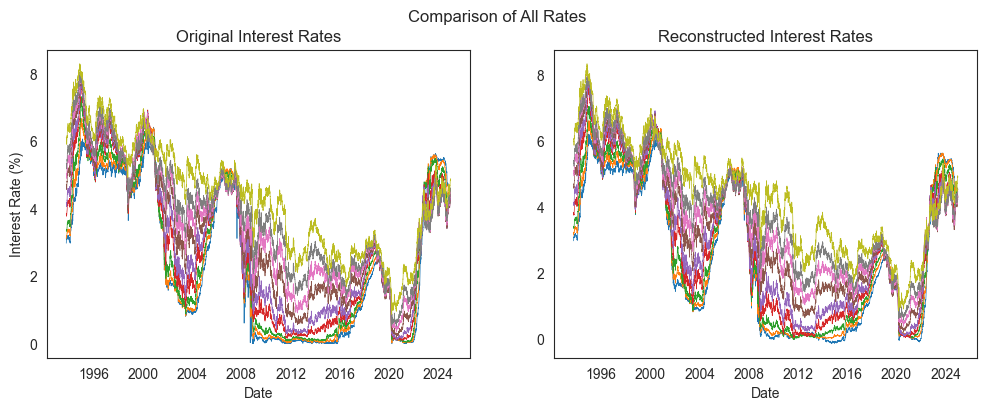

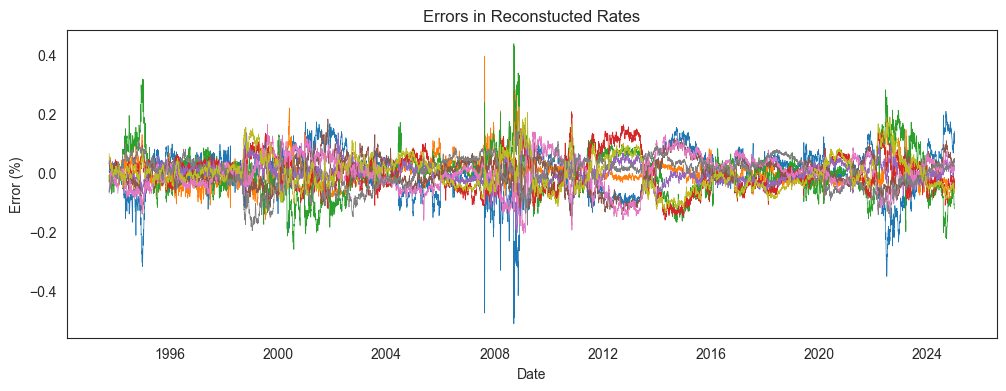

In [16]:
# Reconstruct the standardised interest rates
reconstructed_scaled_rates = np.dot(pc_scores, sorted_eig_vectors[:, :3].T)

# Remove standardisation
reconstructed_rates = scaler.inverse_transform(reconstructed_scaled_rates)

print("Principle Component Score Array Shape:\t", pc_scores.shape)

# Plotting before and after PCA
plot_vars = df.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Comparison of All Rates')
ax[0].plot(df.index, df[plot_vars], lw=0.5)
ax[0].set(title='Original Interest Rates', xlabel='Date', ylabel='Interest Rate (%)')

ax[1].plot(df.index, reconstructed_rates, lw=0.5)
ax[1].set(title='Reconstructed Interest Rates', xlabel='Date')
plt.show()

# Assessing accuracy of recomposition
errors = np.array(df[plot_vars]) - reconstructed_rates

fig, ax = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
ax.plot(df.index, errors, lw=0.5)
ax.set(title='Errors in Reconstucted Rates', xlabel='Date', ylabel='Error (%)')
plt.show()

## Simulation
#### Overview¶
In the upcoming section, we will delve into the application of the Vasicek short-rate model as a forecasting tool for each of the principal components over the next 12 months. This involves leveraging a stochastic model that incorporates mean reversion to simulate interest rate dynamics. The calibration process, facilitated by Maximum Likelihood Estimation (MLE), allows us to determine key parameters such as mean reversion strength (κ), long-run mean (θ), and volatility (σ). Subsequently, Monte Carlo simulations based on the Vasicek model will be employed to project interest rate paths, providing valuable insights into the expected behavior of the principal components over the specified timeframe.

#### Vasicek Model
The Vasicek model, named after economist Oldřich Vašíček, is a stochastic model widely employed in finance to describe the evolution of interest rates over time. Introduced in 1977, the model assumes that interest rates exhibit mean reversion, meaning they tend to move towards a long-term average or equilibrium level.

d
r
(
t
)
=
κ
(
θ
−
r
(
t
)
)
d
t
+
σ
d
W
(
t
)
  
(1)
 
where:

r
(
t
)
 is the short-term interest rate at time
κ
 is the mean reversion strength
θ
 is the long-run mean or the equilibrium interest rate
σ
 is the volatility
d
W
(
t
)
 is a Wiener process (Brownian motion)
Calibration and Simulation Functions
The calibration logic was implemented from the following sources:

https://clinthoward.github.io/portfolio/2017/08/19/Rates-Simulations/
https://github.com/bickez/puppy-economics/blob/master/vasicek.R

In [ ]:
# Mean reversion”_ 
# means that if rates are high, they tend to drift back down toward a long-term average; if they’re low, they drift up.

In [ ]:
def VasicekCalibration(rates, dt=1/252):
    '''
    Calibration function
    '''
    n = len(rates)
    
    Sx = sum(rates.iloc[0:(n-1)])
    Sy = sum(rates.iloc[1:n])
    Sxx = np.dot(rates.iloc[0:(n-1)], rates.iloc[0:(n-1)])
    Sxy = np.dot(rates.iloc[0:(n-1)], rates.iloc[1:n])
    Syy = np.dot(rates.iloc[1:n], rates.iloc[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates.iloc[n-1] # Startpunt = laatste geobserveerde waarde
    
    return [kappa, theta, sigma, r0]

def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):  
    '''
    Simulate next rate
    '''
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out

def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    '''
    Simulate single rate path
    '''
    short_r = [0]*N   # geeft [0,0,0,...] van lengte N
    short_r[0] = r0     
    
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    '''
    Simulate multiple rate paths
    '''
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

#### Calibrate Each Principle Component
The calibrated principle components are being stored in the dataframe df_params so that they can easily be retrieved in the following simulation steps.

In [18]:
loop = 0
for pc in ['PC1','PC2','PC3']:
    params = VasicekCalibration(df_pca[pc].dropna())
    
    if loop==0:
        df_params = pd.DataFrame({'PC':[pc], 'kappa':[params[0]], 'theta':[params[1]], 'sigma': [params[2]]})
        loop += 1
    else:
        tmp = pd.DataFrame({'PC':[pc], 'kappa':[params[0]], 'theta':[params[1]], 'sigma': [params[2]]})
        df_params = pd.concat([df_params, tmp], axis=0)
        loop += 1

df_params = df_params.set_index('PC')
df_params

,kappa,theta,sigma
PC,,,
PC1,0.077153,-0.012139,1.141221
PC2,0.337748,0.125553,0.588297
PC3,1.416092,0.000737,0.324393


#### Simulate Principle Component
The principle components are simulated using the calibrated parameters from the previous step and setting the number of simulation  
M
 .

In [20]:
years = 1
N = years * 252
t = np.arange(0,N)/252
r0 = 0
M = 100

In [ ]:
#diagnostische stap om de kwaliteit en het gedrag van de afzonderlijk gemodelleerde PC's te controleren, voordat ze in de definitieve reconstructie worden samengevoegd

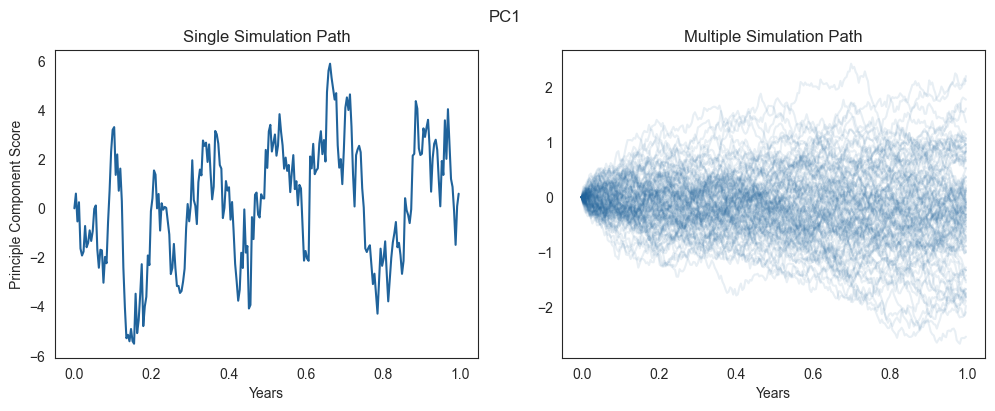

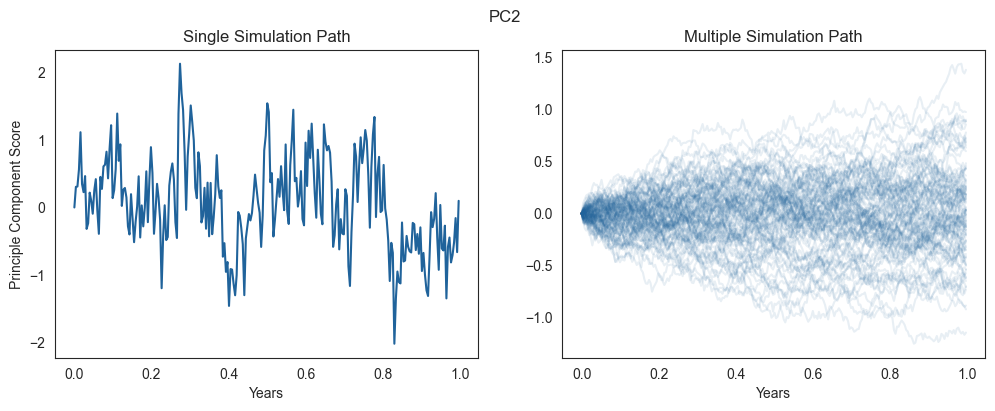

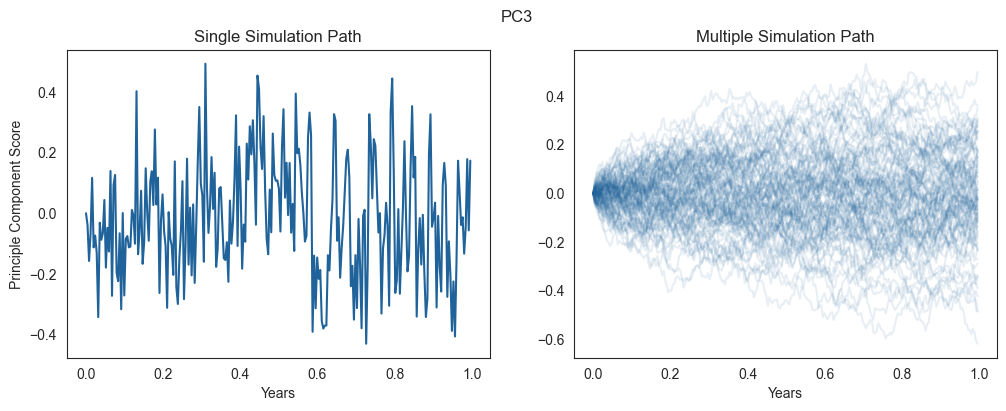

In [21]:
for pc in ['PC1','PC2','PC3']:
    test_sim = VasicekSim(N, r0, df_params.loc[pc, 'kappa'], df_params.loc[pc, 'theta'], df_params.loc[pc, 'sigma'], 1)
    rates_arr = VasicekMultiSim(M, N, r0, df_params.loc[pc, 'kappa'], df_params.loc[pc, 'theta'], df_params.loc[pc, 'sigma'])
    
    fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    plt.suptitle(pc)
    ax[0].plot(t,test_sim, color=c2)
    ax[0].set(title='Single Simulation Path', xlabel='Years', ylabel='Principle Component Score')
    ax[1].plot(t,rates_arr, color=c2, alpha=0.1)
    ax[1].set(title='Multiple Simulation Path', xlabel='Years')
    plt.show()

#### Reconstruct Simulted Interest Rates
The final step in this process is to simulate each of the principle components and reconstruct the interest rates to get the projections for each of the interest rate paths.

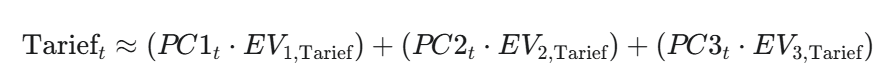

In [ ]:
sim_pc1_arr = VasicekMultiSim(M, N, r0, 
                              df_params.loc['PC1', 'kappa'], 
                              df_params.loc['PC1', 'theta'], 
                              df_params.loc['PC1', 'sigma'])

sim_pc2_arr = VasicekMultiSim(M, N, r0, 
                              df_params.loc['PC2', 'kappa'], 
                              df_params.loc['PC2', 'theta'], 
                              df_params.loc['PC2', 'sigma'])

sim_pc3_arr = VasicekMultiSim(M, N, r0, 
                              df_params.loc['PC3', 'kappa'], 
                              df_params.loc['PC3', 'theta'], 
                              df_params.loc['PC3', 'sigma'])

sim_stack_arr = np.stack((sim_pc1_arr, sim_pc2_arr, sim_pc3_arr), axis=1)
# Combineer de drie afzonderlijke $(N \times M)$ arrays tot één driedimensionale array
print("Shape of PC simulation array:\t", sim_stack_arr.shape)

Shape of PC simulation array:	 (252, 3, 100)


Shape of Interest Rate simulation array:	 (252, 9, 100)


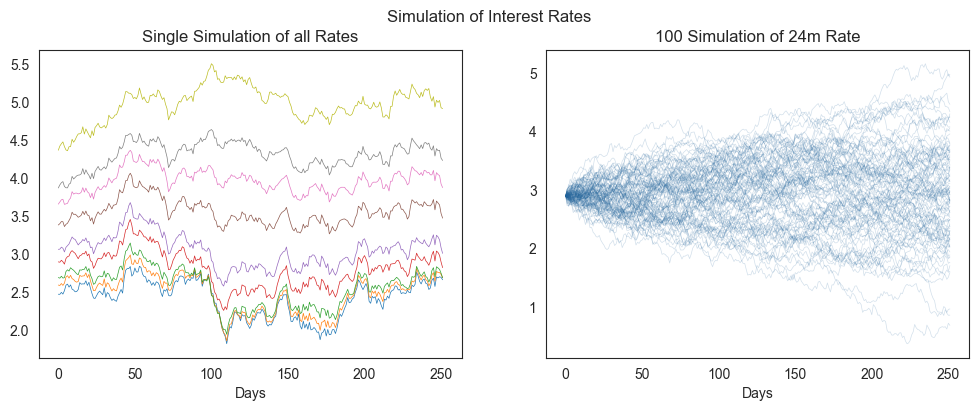

In [ ]:
# Reconstruct the interest rates from the simulated principle components
for i in range(M): # M (100) onafhankelijke toekomstscenario's

    # i-de set van PC-scores (252 dagen x 3 PC's) op en vermenigvuldigt deze met de Eigenvectoren
    # Eigenvectors -> Maturities: The Eigenvectors serve as the weights that map the abstract PC-scores back to the concrete, correlated interest rate changes.
    reconstructed_scaled_rates = np.dot(sim_stack_arr[:,:,i], sorted_eig_vectors[:, :3].T) 
    # geschaalde tarieven worden teruggezet naar hun oorspronkelijke procentuele waarden
    reconstructed_rates = scaler.inverse_transform(reconstructed_scaled_rates)
    
    # voeg toe aan de verzamelarray
    if i == 0:
        rates_sims = reconstructed_rates 
    else:
        rates_sims = np.dstack((rates_sims, reconstructed_rates))

print("Shape of Interest Rate simulation array:\t", rates_sims.shape)

# Plotting the simulated interest rates
plot_vars = df.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Simulation of Interest Rates')

ax[0].plot(reconstructed_rates, lw=0.5) # reconstructed_rates is de laatste simulatie uit de loop
ax[0].set(title='Single Simulation of all Rates', xlabel='Days')

ax[1].plot(rates_sims[:,3,:], color=c2, alpha=0.2, lw=0.5) # rates_sims[:,3,:] is de 2-jaars rente
ax[1].set(title='100 Simulation of {} Rate'.format(plot_vars[3]), xlabel='Days')
plt.show()

#### Conclusions
Hope you found this notebook useful to simulating the interest rate yield curve through principle components. The next steps which I plan to build into this notebook include:

Plotting the 100 simulated yield curves
Determining the confidence intervals for how much the yield curve can change over the next 12m
Experiment with different calibration windows to to assess how this affects the simulation paths in the future
Let me know if you would like to see anything else added to this notebook on this topic. Thanks for reading!